# Computer Vision - ENCS5343 **(Course Project -  Arabic Handwritten Character Recognition (AHCR) using Convolutional Neural Networks (CNNs).)**
## Team Members:


*   Diaeddin Tahboub - 1200136
*   Hamza Najar - 1192605

## Instructor: Dr. Aziz Qaroush
## Section: 2
## Date: 31/1/2024



---



## Introduction:
* This project objects to define the main building blocks of a Convolutional Neural Network, define loos functions and optimizers examine different models on the same datasets to determine the effect of increasing/decreasing the complexity of the Convolutional Neural Network, and the effect of performing data augmentation on the training data and fine-tuning a pre-trained neural network on a similar task to use it on our dataset.

## The procedure is described using 4 steps:


1.   Loading, preparing the data and get an augmented copy of it.
2.   Building the neural networks and apply hyperparameter tuning.
3.   train each network and plot the Accuracy/Loss curves.
4.   Compare between the results.



### Step 0: Import the important libraries.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F

### Step 1: Loading and preparing the data.

#### 1.0 Defining the datast:
* Our dataset is a bunch of images for 28 letters from the arabic alphabet, each images is a grayscale image of size `32x32` pixels.

#### 1.1 Prepare the data path to successfully import them into the notebook

In [ ]:
dataset_path = Path('./Dataset/')
train_data_path = dataset_path / "train dataset"
test_data_path = dataset_path / "test dataset"

#### 1.2 Unzip the `Dataset` file

In [1]:
# If you are using Google Colab, please upload the Dataset.zip file before starting, else comment the line below to avoid errors
# After running this cell for the first time, comment the line below please in order to avoid unzipping the Dataset folder again
# !unzip Dataset.zip

#### 1.3 Set up the device to be cuda:0 because that will speed up the learning and testing processes

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"We are now using {device} device")

We are now using cuda:0 device


#### 1.4 Build a function to import the data from the dataset folder

In [ ]:
def upload_images(train_data_path, test_data_path):
    """Function to import the data from the dataset folder
    INPUTS:
    train_data_path (pathlib.Path object): an object holding the path to the training dataset
    test_data_path (pathlib.Path object): an object holding the path to the testing dataset

    OUTPUTS:
    train_data (python list): a list that holds the image and its label in each element of it (training images).
    train_data_to_augment (python list): a list that holds the image and its label in each element of it (copy of the training images).
    test_data (python list): a list that holds the image and its label in each element of it (testing images).
    """
    # Initialized the lists that will hold the images and their labels
    train_data = []
    test_data = []
    # Initialized this list to carry a copy of the training data to avoid editing the original data when augmenting it
    train_data_to_augment = []

    # os.listdir(path) returns the names of the files inside the directory of `path`
    for filename in list(os.listdir(train_data_path)): # For loop to get the file names of all images inside the directory holding the training dataset

        # Appending the image with its label to the training dataset lists
        train_data.append([cv2.imread(str(train_data_path/filename), cv2.IMREAD_GRAYSCALE) / 255.0, int(filename.split(".")[0].split("_")[-1]) - 1]) # Applied the normalizarion to speed up the learning process
        train_data_to_augment.append([cv2.imread(str(train_data_path/filename), cv2.IMREAD_GRAYSCALE) / 255.0, int(filename.split(".")[0].split("_")[-1]) - 1]) # Applied the normalizarion to speed up the learning process

    for filename in list(os.listdir(test_data_path)): # For loop to get the file names of all images inside the directory holding the testing dataset

        # Appending the image with its label to the testing dataset list
        test_data.append([cv2.imread(str(test_data_path/filename), cv2.IMREAD_GRAYSCALE) / 255.0 , int(filename.split(".")[0].split("_")[-1]) - 1]) # Applied the normalizarion to speed up the testing process

    return train_data, test_data, train_data_to_augment

#### 1.5 Build a function to augment the data(images)

In [ ]:
def augment_images(train_data):
  """Function that augments the data and returns it
  INPUTS:
  train_data (python list): a list that holds the image and its label in each element of it (training images).

  OUTPUTS:
  train_data (python list): a list that holds the augmented image and its label in each element of it (training images).
  """

  # Function to apply random rotation on the image
  def random_rotation(image, degrees=10, p=0.5):
    if np.random.rand() < p:
        rows, cols = image.shape
        angle = np.random.uniform(-degrees, degrees)
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    return image

  # Function to apply random horizontal flip on the image
  def random_horizontal_flip(image, p=0.5):
      if np.random.rand() < p:
          image = cv2.flip(image, 1)  # 1 for horizontal flip
      return image

  # Function to apply random vertical flip on the image
  def random_vertical_flip(image, p=0.5):
      if np.random.rand() < p:
          image = cv2.flip(image, 0)  # 0 for vertical flip
      return image

  # For loop to iterate over all the images in the `train_data` list and augment them
  for i in range(len(train_data)):
    train_data[i][0] = random_rotation(train_data[i][0])
    train_data[i][0] = random_horizontal_flip(train_data[i][0])
    train_data[i][0] = random_vertical_flip(train_data[i][0])


  return train_data

#### 1.6 Import the data and apply augmentation

In [ ]:
train_data, test_data, train_augment = upload_images(train_data_path, test_data_path)
validation_data = test_data[:1680]
test_data = test_data[1680:]
train_data_augmented = augment_images(train_augment)

### 2. Build the neural network models

#### 2.0 Brief overview of CNN models
##### Description:
* Each CNN model consists of two main blocks, the convolutional block which contains Convolutional layers, pooling layers and batch normalization layers, and the classifier layer (known as the fully connected layer) which contains an input layer to receive the inputs, some hidden layers to learn patterns in the data and the output layer to give the final output.

* Here are the descriptions of each component used in the CNN classes:


1.   nn.Module: Base class for all neural network modules. **Your CNN/ANN/RNN classes should inherit this class and override the `.forward()` method**.
2.   nn.Conv2d(in_channels, out_channels, kernel_size, padding): a convolutional layer that consists of (out_channels) filters (kernels), each kernel has (in_channels) channels of size (kernel_size x kernel_size) **Stride here is automatically set to `1`**. The padding is added to make the filter pass over each pixel on the image the same number of passes on all the other pixels but there is a condition that must hold: $$p = floor((f - 1)/2)$$
3. nn.ReLU(): An activation function that could be applied to the outputs of the layers.
4. nn.MaxPool2d(kernel_size): a pooling layer that applies the max function over a subset pixels of size (kernel_size x kernel_size) **Stride here is automatically set to `kernel_size`**.
5. nn.Linear(in_features, out_features): a layer that contains `out_features` neurons and receives `in__features` features.

##### In general, each pooling/convolutional gives an output image that could have different hegiht, width and  number of channels than the input image using the following formula:
* $HeightOut = ((HeightIn - k + 2p) / s) + 1$

* $WidthOut = ((WidthIn - k + 2p) / s) + 1$

* ChannelsOut = NumberOfFilters

where:
* s: the stride (the shift size (moves from left to right in the row and then jumps to the next row) after each convolution/pooling)
* k: kernel size
* p: padding size


#### 2.1 First CNN: My custom CNN
##### Assume the input image is nxHxW (the PyTorch Represetation) where n is the number of channels (1 in the grayscale images case)
##### Convolutional block:
* Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1) -> output shape: 10xHxW
* ReLU() -> output shape: no change
* MaxPool2d(kernel_size=2) -> output shape: 10x(H/2)x(W/2)
* Conv2d(in_channels=10, out_channels=40, kernel_size=3, padding=1) -> output shape: 40x(H/2)x(W/2)
* ReLU() -> output shape: no change
* MaxPool2d(kernel_size=2) -> output shape: 10x(H/4)x(W/4)
* Conv2d(in_channels=40, out_channels=80, kernel_size=3, padding=1) -> output shape: 40x(H/2)x(W/2)
* ReLU() -> output shape: no change
* MaxPool2d(kernel_size=2) -> output shape: 80x(H/8)x(W/8)
##### Here the image shape is 1x32x32 then the output shape of the convolutional block is: 80x4x4, then the input layer of the classifier block should receive 80 * 4 * 4 features.
##### Classifier block:
* Linear(in_features=4 * 4 * 80, out_features=64) -> output shape: 64
* ReLU() -> output shape: no change
* Linear(in_features=64, out_features=128) -> output shape: 128
* ReLU() -> output shape: no change
* Linear(in_features=128, out_features=256) -> output shape: 256
* ReLU() -> output shape: no change
* Linear(in_features=256, out_features=28) -> output shape: 28 (number of arabic alphabets)
* ReLU() -> output shape: no change

In [ ]:
class CNNModelV0(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=10, out_channels=40, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=4 * 4 * 80, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=28)
        )
    def forward(self, x):
        x = self.cnn_layer(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x
model_0 = CNNModelV0().to(device)
model_0_augmented = CNNModelV0().to(device)

#### 2.2 VGG architecture model
* Overview: the same as the VGG16 CNN architecture but with changing the `in_channels` in the first convolutional layer from `3` to `1` to receive grayscale images instead of RGB ones.
##### Convolutional block:
* Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) -> output shape: 64xHxW
* ReLU() -> output shape: no change
* Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) -> output shape: 64x(H)x(W)
* ReLU() -> output shape: no change
* MaxPool2d(kernel_size=2) -> output shape: 64x(H/2)x(W/2)
* Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) -> output shape: 128x(H/2)x(W/2)
* ReLU() -> output shape: no change
* Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1) -> output shape: 128x(H/2)x(W/2)
* ReLU() -> output shape: no change
* MaxPool2d(kernel_size=2) -> output shape: 128x(H/4)x(W/4)
##### Since our images have the shape 1x32x32 then the output shape of the convolutional block is: 128x8x8, then the input layer of the classifier block should receive 128 * 8 * 8 features.
##### Classifier block:
* Linear(in_features=128 * 8 * 8, out_features=256) -> output shape: 256
* ReLU() -> output shape: no change
* Linear(in_features=256, out_features=num_classes) -> output shape: num_classes=28 in our case

In [ ]:
class VGGGray(nn.Module):
    def __init__(self, num_classes=28):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
model_1 = VGGGray().to(device)


#### 2.3 Pre - trained model
* Source: `https://www.kaggle.com/code/oykuer/mnist-digit-recognition-pytorch-99/output`
##### Brief description: this model was used ro classify the hand-written digits in the popular MNIST digits dataset where the digits were represented as `1x28x28` (grayscale images) there, and it gave some good results such as 99% accuracy. Since our task is similar to classifying hand-written digits, it could be beneficial to use this model.

##### Convolutional block:
* Conv2d(1,32,5,1,padding=2) -> output shape: 32xHxW
* ReLU() -> output shape: no change
* Conv2d(32,32,5,1,padding=2) -> output shape: 32xHxW
* ReLU() -> output shape: no change
* MaxPool2d(kernel_size = 2, stride=2) -> output shape: 32x(H/2)x(W/2)
* Dropout(0.25), used to reduce the overfitting of the model -> output shape: no change
* Conv2d(32,64,3,1,padding=1) -> output shape: 64x(H/2)x(W/2)
* ReLU() -> output shape: no change
* Conv2d(64,64,3,1,padding=1) -> output shape: 64x(H/2)x(W/2)
* ReLU() -> output shape: no change
* MaxPool2d(kernel_size=2) -> output shape: 64x(H/4)x(W/4)
* Dropout(0.25), used to reduce the overfitting of the model -> output shape: no change
##### Since our images have the shape 1x32x32 then the output shape of the convolutional block is: 64 * 8 * 8, then the input layer of the classifier block should receive 64 * 8 * 8 features.
##### Classifier block:
* Linear(in_features=3136, out_features=1568) -> output shape: 1568 -> the `3136` parameter will be changed to `8 * 8 * 64` because our images size is `32x32` and the images that the model built for have size `28x28`.
* ReLU() -> output shape: no change
* Dropout(0.50), used to reduce the overfitting of the model -> output shape: no change
* Linear(in_features=1568, out_features=num_classes) -> output shape: 28

In [ ]:
class DigitModel(nn.Module):
    def __init__(self):
        super(DigitModel,self).__init__()
#         in channel, out channel, kernel , stride
        self.conv1 = nn.Conv2d(1,32,5,1,padding=2)
        self.conv2 = nn.Conv2d(32,32,5,1,padding=2)
#         self.bn1 = nn.BatchNorm2d(32)
        self.maxp1 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.conv3 = nn.Conv2d(32,64,3,1,padding=1)
        self.conv4 = nn.Conv2d(64,64,3,1,padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
        self.maxp2 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.fc1 = nn.Linear(3136,1568)
        self.fc2 = nn.Linear(1568,10)
        self.dr1 = nn.Dropout(0.25)
        self.dr2 = nn.Dropout(0.50)

    def forward(self,x):

        # Convolution 1
        x = F.relu(self.conv1(x))

        # Convolution 2
        x = self.maxp1(F.relu(self.conv2(x)))
        x = self.dr1(x)

        # Convolution 3
        x = F.relu(self.conv3(x))
        x = self.maxp2(F.relu(self.conv4(x)))
        x = self.dr1(x)

        # Flatten
        x = torch.flatten(x,1)

        # FC 1
        x = F.relu(self.fc1(x))
        x = self.dr2(x)

        # FC 2
        x = self.fc2(x)
        return x



# Explanation: because our images size is 32x32 and
model_2 = DigitModel()
model_2.load_state_dict(torch.load('./model_augmented.pt'))
model_2 = model_2.to(device)

for name, param in model_2.named_parameters():
    if 'conv' in name:
        param.requires_grad = False

model_2.fc1 = nn.Linear(8 * 8 * 64, 1568).to(device)
model_2.fc2 = nn.Linear(1568, 28).to(device)

model_2_trainable = DigitModel()
model_2_trainable.fc1 = nn.Linear(8 * 8 * 64, 1568).to(device)
model_2_trainable.fc2 = nn.Linear(1568, 28).to(device)
model_2_trainable = model_2_trainable.to(device)


model_2_original = DigitModel()
model_2_original.load_state_dict(torch.load('./model_augmented.pt'))
model_2_original = model_2_original.to(device)

for name, param in model_2_original.named_parameters():
    if 'conv' in name:
        param.requires_grad = False

model_2_original.fc1 = nn.Linear(8 * 8 * 64, 1568).to(device)
model_2_original.fc2 = nn.Linear(1568, 28).to(device)


### 3. train each network and plot the Accuracy/Loss curves.
#### We have to plot 4 curves for each model:
1. Training loss vs. epoch.
2. Validation loss vs. epoch.
3. Training accuracy vs. epoch.
4. Testing accuracy vs. epoch.


#### 3.0 Build the function that will:
1. Train the model
2. plot the 4 curves for each model
* Loss function: s a function that maps an event or values of one or more variables onto a real number intuitively representing some "cost" associated with the event. An optimization problem seeks to minimize a loss function. An objective function is either a loss function or its opposite (in specific domains, variously called a reward function, a profit function, a utility function, a fitness function, etc.), in which case it is to be maximized. The loss function could include terms from several levels of the hierarchy.
* Cross-entropy loss, often referred to as log loss, is a loss function used in machine learning and specifically in the context of classification problems. It measures the performance of a classification model whose output is a probability value between 0 and 1. The loss increases as the predicted probability diverges from the actual class label.
Formula: <br>$H(y, y')=−(y⋅log(y')+(1−y)⋅log(1− y'))$
* Optimizdrs: algorithms or methods used to minimize (or maximize) an objective function. The objective function typically represents the loss or cost associated with the model's predictions on the training data. Optimizers adjust the parameters of a model to minimize this objective function, enabling the model to learn from the data.
* Adam Optimizer: an optimization algorithm that combines ideas from two other popular optimizers: RMSprop and Momentum. It is particularly effective in training deep neural networks.
* Benefits of Adam: 
1. Adaptive Learning Rates: Adam adapts the learning rates for each parameter individually based on the historical gradients. This adaptability helps handle sparse gradients and varying magnitudes of gradients across different parameters.
2. Momentum-Like Behavior: Adam incorporates the concept of momentum, which helps accelerate convergence by accumulating the past gradients. This momentum-like behavior allows the optimizer to continue moving in the right direction even when the gradient signals are noisy.
3. Bias Correction: Adam performs bias correction during the early steps of training, compensating for the fact that the first and second moments are initialized at zero. This correction helps stabilize the optimization process, especially in the initial training stages.

In [ ]:
def train_and_validate_model_and_visualize(model, epochs, model_name, apply_data_augmentation=False, device=device):
  """Function to train the model and plot the 4 curves specified above
  INPUTS:
  model (nn.Module object): the model to be trained
  epochs (integer): the number of epochs we want to train our model over
  model_name (string): the name of our model to use when plotting
  apply_data_augmentation (boolean): to determine to use the augmented images or the original
  device (string): the device we sent the models to (cpu or cuda:0)
  OUTPUTS:
  float: the last epoch's training accuracy
  float: the last epoch's test accuracy
  """

  # Our datasets as global variables
  global train_data, test_data, validation_data, train_data_augmented

  # Turn the datasets into DataLoaders in order to pass them to the model properly
  validation_dataloader = DataLoader(dataset=validation_data, batch_size=32)
  test_dataloader = DataLoader(dataset=test_data, batch_size=32)

  # If the condition here is True, then we will use the augmented data
  if apply_data_augmentation:
    train_dataloader = DataLoader(dataset=train_data_augmented, batch_size=32)
  else:
    train_dataloader = DataLoader(dataset=train_data, batch_size=32)
  # Lists that will contain: train and validation loss for epoch, and train and test accuracy for each epoch
  epoch_train_losses = []
  epoch_valid_losses = []
  epoch_train_accuracies = []
  epoch_test_accuracies = []

  # Define the loss function (CrossEntropyLoss in our case because our class is multi-class classification)
  criterion = nn.CrossEntropyLoss()

  # The optimizer that will optimize the parameters of our model
  optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())

  # For loop to iterate (epochs) times
  for epoch in range(epochs):

    # To set the model in the training situation
    model.train()

    # Variable to sum up the training losses of all the epochs
    epoch_loss = 0.0

    # Variable to count the number of the correctly classified training examples (to obtain the training accuracy)
    correct_predictions = 0

    # Varibale to count the number of samples for each batch
    total_samples = 0

    # For loop to iterate over the batches of the training set
    for i, data in enumerate(train_dataloader, 0):

        # Extract the data into inputs (for the model) and labels
        inputs, labels = data

        # Send the inputs and the labels to the specified device
        inputs = inputs.to(device).float().unsqueeze(1)
        labels = labels.to(device)

        # Gather the outputs of the model
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Make the gradients zero before applying the back-propagation step
        optimizer.zero_grad()

        # Apply back-propagation
        loss.backward()

        # Updae the parameters of the model
        optimizer.step()

        # Get the batch loss and increase the `epoch_loss` variable by it
        epoch_loss += loss.item()

        # Get the labels of the model's outputs
        _, predicted = outputs.max(1)

        # Increase the `correct_predictions` varibale by the number of correctly classified examples
        correct_predictions += (predicted == labels).sum().item()

        # Increase the `total_samples` varibale by the number of samples in the batch in the specified epoch
        total_samples += labels.size(0)

    # Calculate the epoch accuracy
    accuracy = correct_predictions / total_samples

    # Append the epoch accuracy to the list of training accuracies
    epoch_train_accuracies.append(accuracy)

    # Calculate the epoch loss
    average_epoch_loss = epoch_loss / len(train_dataloader)

    # Append the epoch loss to the list of training losses
    epoch_train_losses.append(average_epoch_loss)

    # To set the model in the freeze mode (will not be trained)
    with torch.inference_mode():
      model.eval()

      # Variable to count the number of the correctly classified testing examples (to obtain the testing accuracy)
      total_correct = 0

      # Varibale to count the number of samples for each batch
      total_samples = 0

      # For loop to iterate over the testing batches
      for i, data in enumerate(test_dataloader, 0):

        # Extract the data into inputs (for the model) and labels
        inputs, labels = data

        # Send the inputs and the labels to the specified device
        inputs = inputs.to(device).float().unsqueeze(1)
        labels = labels.to(device)

        # Gather the probabilities of the model's outputs
        outputs = F.softmax(model(inputs), 1)

        # Gather the labels of the model's outputs
        _, predicted_labels = torch.max(outputs, 1)

         # Increase the `correct_predictions` varibale by the number of correctly classified examples
        total_correct += (predicted_labels == labels).sum().item()

        # Increase the `total_samples` varibale by the number of samples in the batch in the specified epoch
        total_samples += labels.size(0)

      # Calculate the epoch accuracy
      test_accuracy = total_correct / total_samples

      # Append the epoch accuracy to the list of testing accuracies
      epoch_test_accuracies.append(test_accuracy)

    # To set the model in the freeze mode (will not be trained)
    with torch.inference_mode():
      model.eval()

      # Variable to sum up the validation losses of all the epochs
      epoch_loss = 0

      # For loop to iterate over the validation batches
      for i, data in enumerate(validation_dataloader, 0):

        # Extract the data into inputs (for the model) and labels
        inputs, labels = data

        # Send the inputs and the labels to the specified device
        inputs = inputs.to(device).float().unsqueeze(1)
        labels = labels.to(device)

        # Gather the outputs of the model
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Get the batch loss and increase the `epoch_loss` variable by it
        epoch_loss += loss.item()

      # Calculate the epoch loss
      average_valid_loss = epoch_loss / len(validation_dataloader)

      # Append the epoch loss to the list of validation losses
      epoch_valid_losses.append(average_valid_loss)

  # Plotting
  plt.figure(figsize=(12, 8))
  plt.suptitle(f'{model_name} Training and Evaluation Results', fontsize=16)
  # Training and Validation Loss
  plt.subplot(2, 2, 1)
  plt.plot(range(1, epochs+1), epoch_train_losses, label='Training Loss', marker='o')
  plt.plot(range(1, epochs+1), epoch_valid_losses, label='Validation Loss', marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  # Training Accuracy
  plt.subplot(2, 2, 2)
  plt.plot(range(1, epochs+1), epoch_train_accuracies, label='Training Accuracy', marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy')

  # Testing Accuracy (optional)
  plt.subplot(2, 2, 3)
  plt.plot(range(1, epochs+1), epoch_test_accuracies, label='Testing Accuracy', marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Testing Accuracy')

  plt.tight_layout()
  plt.show()

  return epoch_train_accuracies[-1], epoch_test_accuracies[-1]

#### 3.1 My model results and curves for the orignal data (not augmented)

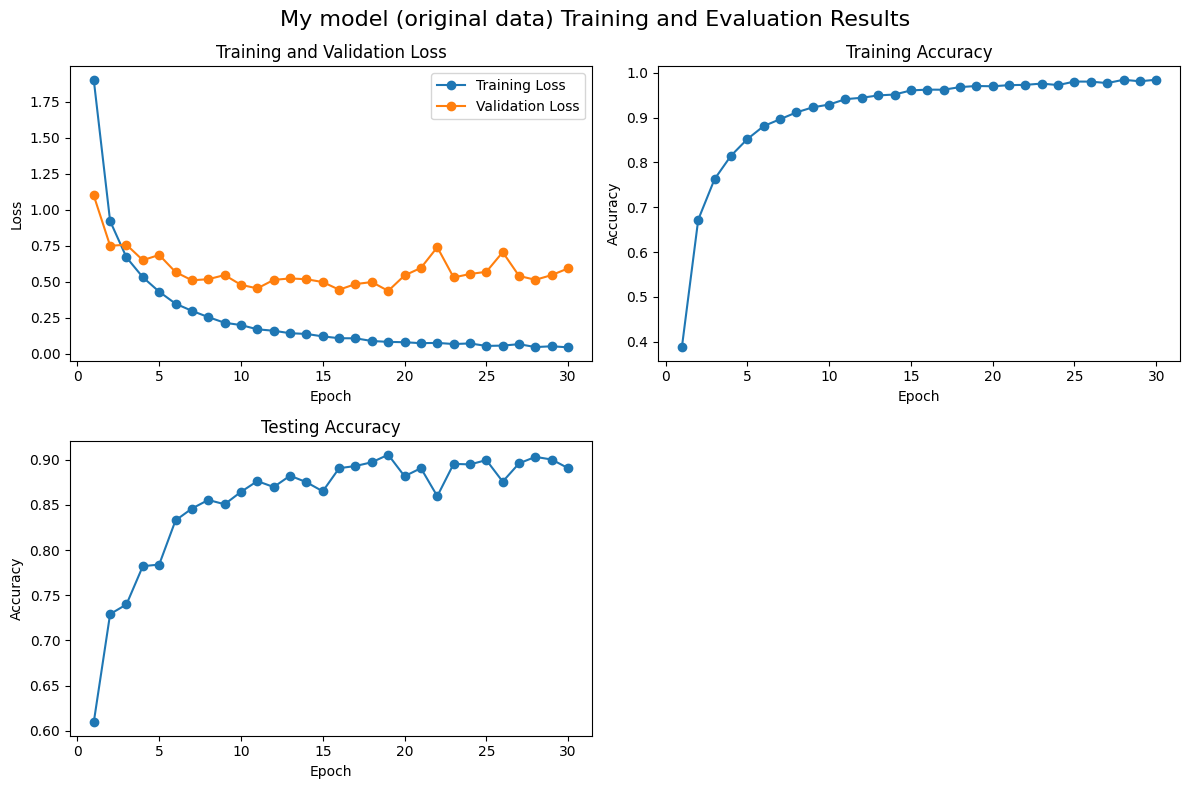

My custom model results (with no data augmentation): training accuracy: 0.984672619047619, testing accuracy: 0.8904761904761904


In [ ]:
training_acc, test_acc = train_and_validate_model_and_visualize(model_0, 30, "My model (original data)")
print(f"My custom model results (with no data augmentation): training accuracy: {training_acc}, testing accuracy: {test_acc}")

##### Result: We can see that the model is good in both testing accuracy and training accuracy, but there is a noticable difference between which is determeined as overfitting.

#### 3.2 My model results and curves (with the augmented data)

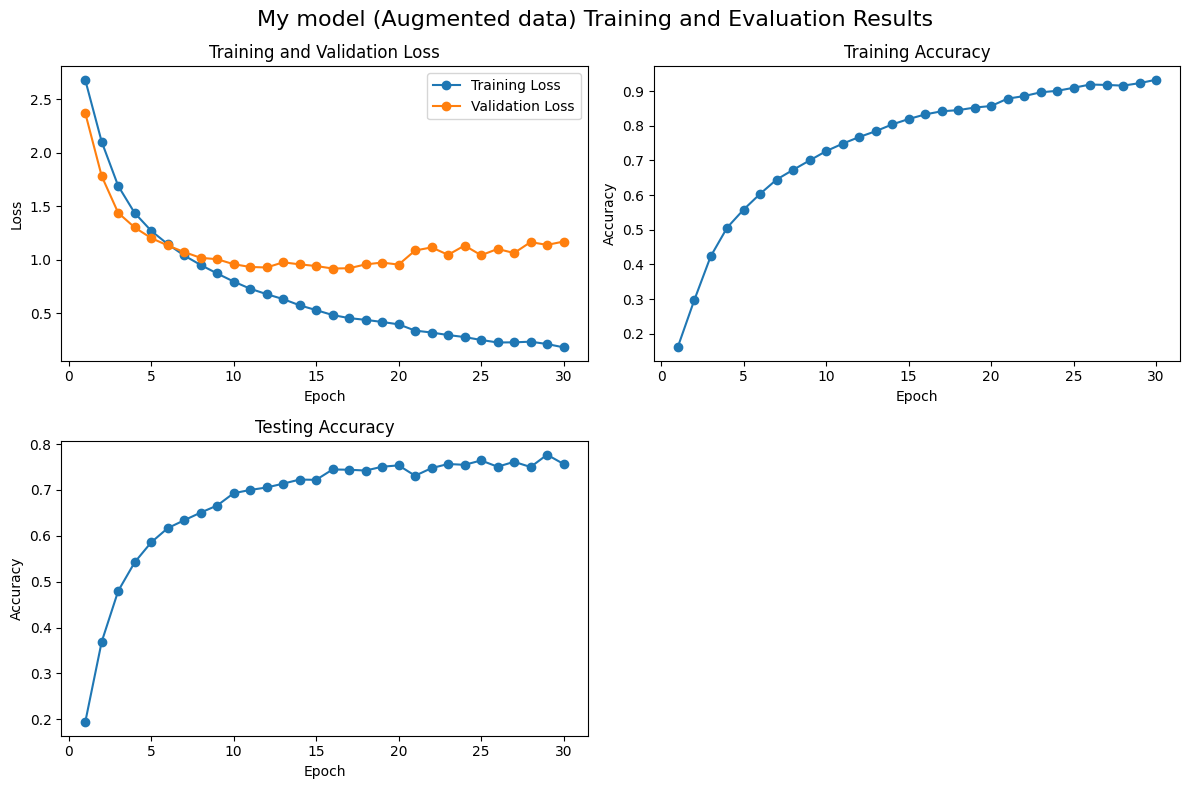

My custom model results (with data augmentation): training accuracy: 0.9328869047619047, testing accuracy: 0.756547619047619


In [ ]:
training_acc, test_acc = train_and_validate_model_and_visualize(model_0_augmented, 30, "My model (Augmented data)", True)
print(f"My custom model results (with data augmentation): training accuracy: {training_acc}, testing accuracy: {test_acc}")

##### We can see that the model is good at learning but bad at generalizing since the difference between the testing accuracy and the training accuracy is large and this situation is determined as overfitting.
* The custom model with the augmented data is doing worse than the model with the original data since the training accuracy `93.2%` and the testing accuracy `75%` are less than the training accuracy and the testing accuracy in the case with original data (`98.5%` and `89%` repectively).

#### 3.3 VGG-like model results and curves with augmented data

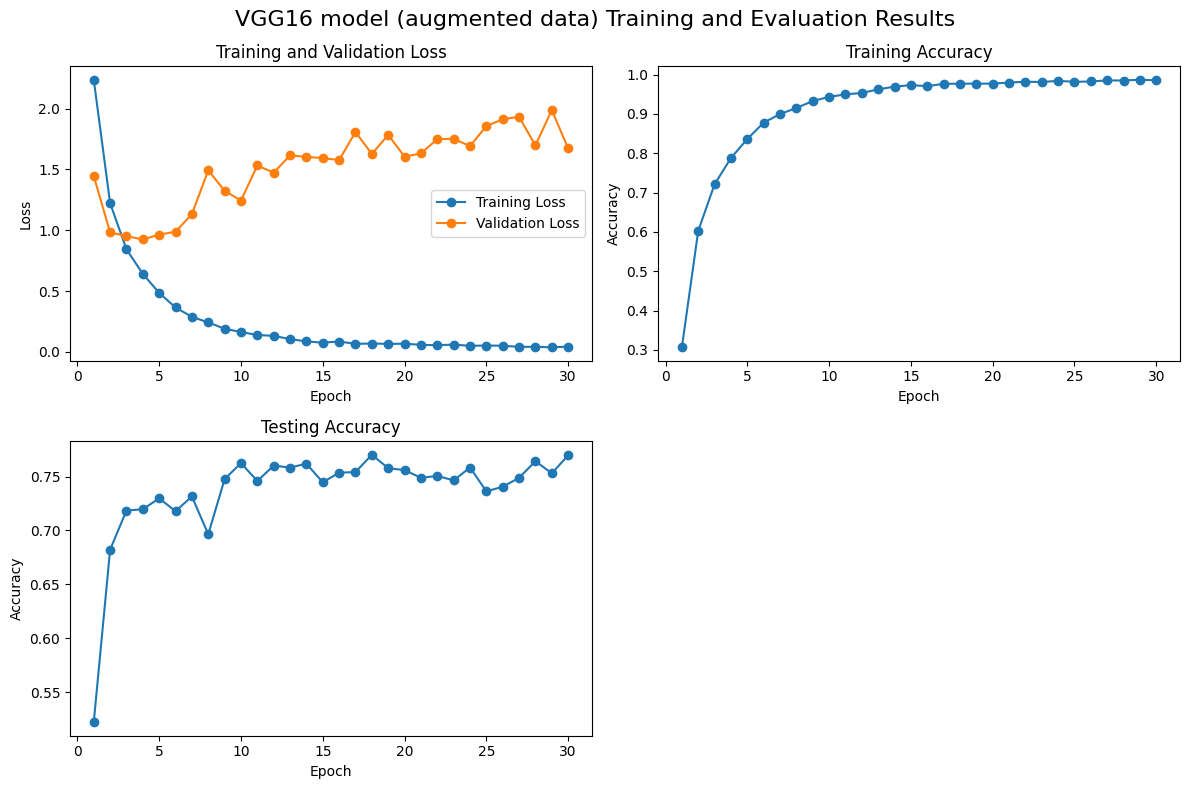

VGG16 model results (with data augmentation): training accuracy: 0.9853422619047619, testing accuracy: 0.7696428571428572


In [ ]:
training_acc, test_acc = train_and_validate_model_and_visualize(model_1, 30, "VGG16 model (augmented data)", True)
print(f"VGG16 model results (with data augmentation): training accuracy: {training_acc}, testing accuracy: {test_acc}")

###### We can see that the VGG-like model is very good at learning but bad in generalizing since the differnce between the testing accuracy and the training accuracy is large and the situation is determined as overfitting.
* The VGG-like model is overfitting.
* We can see that testing accuracy for the VGG-like model (`~77%`) is a little higher than in the custom model (with the augmented data) (`75%`) but the training accuracy (`98.5%`) is higher than in the custom model with augmented data (`93%`).
* We can see that testing accuracy for the VGG-like model (`~77%`) is lower than in the custom model (with the origianl data) (`89%`) but the training accuracy (`98.5%`) is approximately the same as in the custom model with original data (`98.467%`).
* Then the VGG-like model is better than the custom model with the augmented data in learning but worse than the custom model with the original data in generalizing.  

#### 3.4 Pre-trained model results and curves with the augmented data

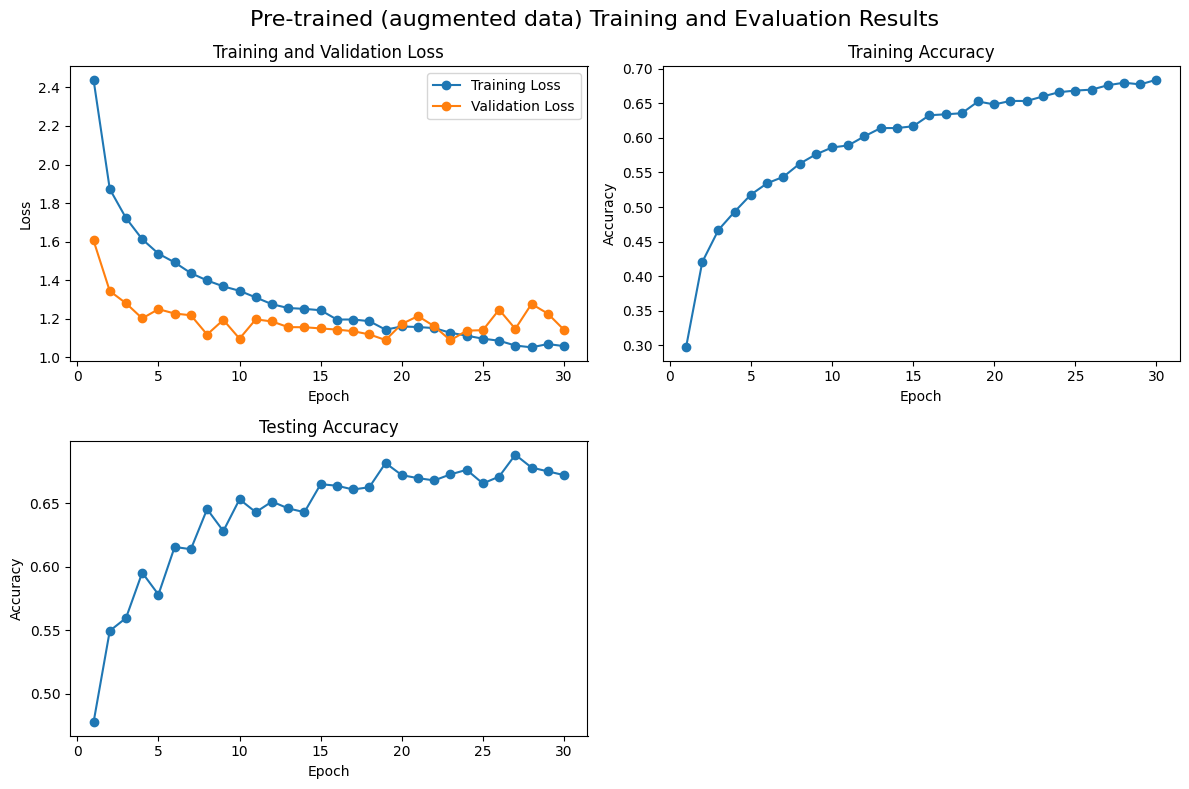

The pre-trained model results (with data augmentation): training accuracy: 0.6840773809523809, testing accuracy: 0.6720238095238096


In [ ]:
training_acc, test_acc = train_and_validate_model_and_visualize(model_2, 30, "Pre-trained (augmented data)", True)
print(f"The pre-trained model results (with data augmentation): training accuracy: {training_acc}, testing accuracy: {test_acc}")

###### We can see that the model cannot learn much since it stopped in both training accuracy and the testing accuracy in around `67%` then the model is not good at learning and worse than all the other models.
* This happened because the owner of this model did not apply any data augmentation techniques to the data, so the model could not learn that variations in the classifier block only (it needs to learn them in the convolutional block since we are dealing with images).

#### 3.5 Trying the pre-trained model with the original data to see if the idea of transfer learning worked here




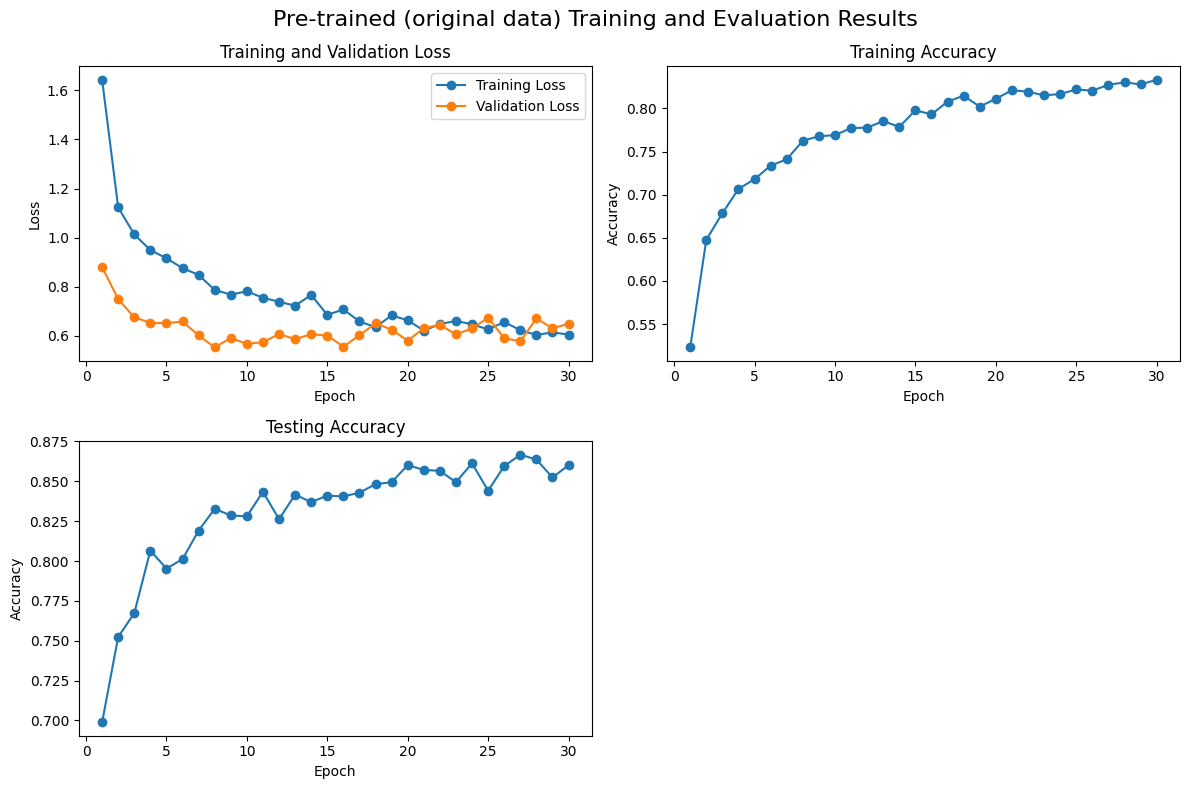

The pre-trained model results (with original data): training accuracy: 0.8331845238095238, testing accuracy: 0.8601190476190477


In [ ]:
training_acc, test_acc = train_and_validate_model_and_visualize(model_2_original, 30, "Pre-trained (original data)")
print(f"The pre-trained model results (with original data): training accuracy: {training_acc}, testing accuracy: {test_acc}")

##### The pre-trained model has proved that the transfer learning is useful in saving some time and effort, the model has really learned the features of the digits and it could generalize to a similar task (which can be our task) since the the training and testing accuracies are not that bad.
* The model can generalize better than all the other models and does not overfit like them, but its training accuracy is lower than in the custom model with original data and the testing accuracy is close (a little).

#### 3.6 Experimental model (we will train a model which is similar to the pre-trained model in the architecture from the 0)

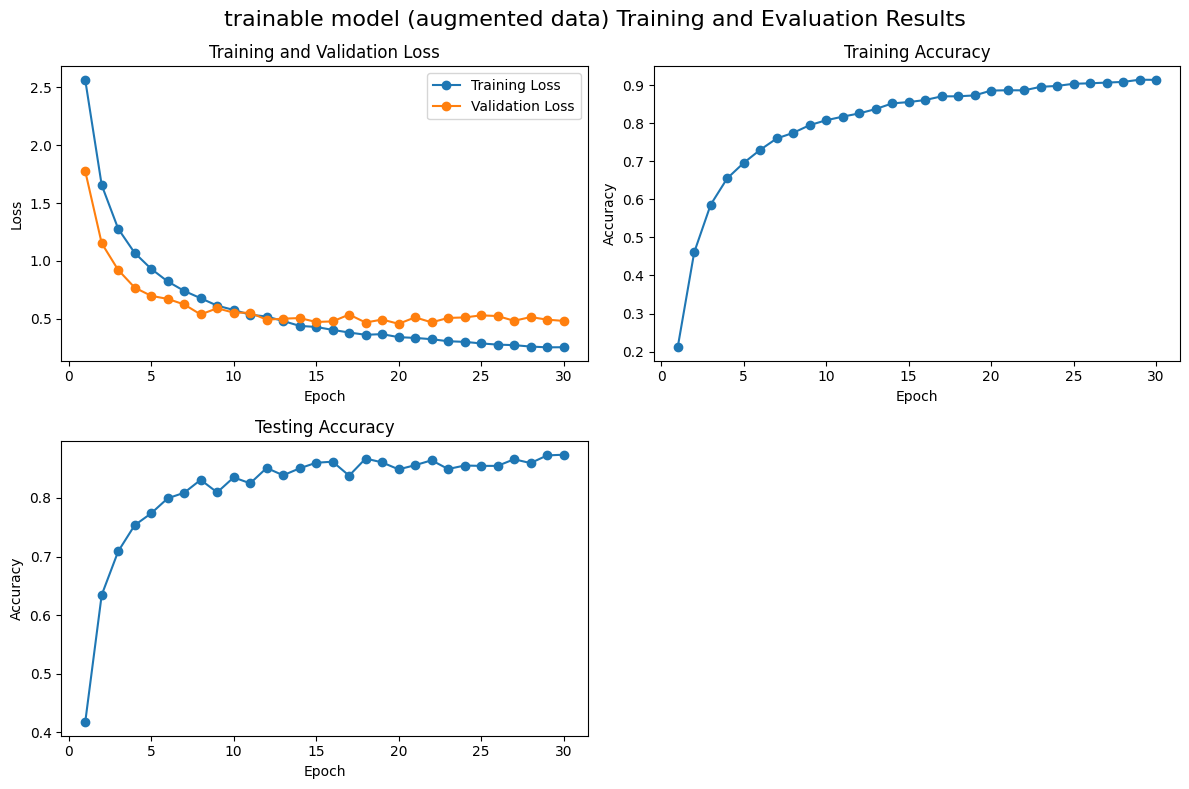

The trainable model results (with data augmentation): training accuracy: 0.9136160714285714, testing accuracy: 0.8738095238095238


In [ ]:
training_acc, test_acc = train_and_validate_model_and_visualize(model_2_trainable, 30, "trainable model (augmented data)", True)
print(f"The trainable model results (with data augmentation): training accuracy: {training_acc}, testing accuracy: {test_acc}")

##### We can see that the model is good at learning from zero, it does not overfit that much and its testing and training accuracy are good.

### 4. Comparison
* The best model with the augmented data was the experimental one since it has a good accuracy in both training and testing and it does not overfit (it can generalize).
* The best model with the original (not augmented) data was the custom model since It has the highest accuracy in both testing and training.  

### 5. Conclusion
* We learned from the project that not all models can generalize even if they are complex and contain tons of layers, the test accuracy could increase when increasing the complexity and could decrease (which could lead to overfitting like what we saw in the project) so there are no gaurantees. We have learned that the transfer learning aproach could be very useful in saving time and effort especially when the tasks are similar to each other and we can get the maximum benefit when we are sure that the data preprocessing techniques we are using are the same that are used with the data that the model hsa been pre-trained on.